Pneumonia is one of the leading respiratory illnesses worldwide, and its timely and accurate diagnosis is essential for effective treatment. Manually reviewing chest X-rays is a critical step in this process, and AI can provide valuable support by helping to expedite the assessment. In your role as a consultant data scientist, you will test the ability of a deep learning model to distinguish pneumonia cases from normal images of lungs in chest X-rays.

By fine-tuning a pre-trained convolutional neural network, specifically the ResNet-18 model, your task is to classify X-ray images into two categories: normal lungs and those affected by pneumonia. You can leverage its already trained weights and get an accurate classifier trained faster and with fewer resources.

## The Data

<img src="../extra/x-rays_sample.png" align="center"/>
&nbsp

You have a dataset of chest X-rays that have been preprocessed for use with a ResNet-18 model. You can see a sample of 5 images from each category above. Upon unzipping the `chestxrays.zip` file (code provided below), you will find your dataset inside the `data/chestxrays` folder divided into `test` and `train` folders. 

There are 150 training images and 50 testing images for each category, NORMAL and PNEUMONIA (300 and 100 in total). For your convenience, this data has already been loaded into a `train_loader` and a `test_loader` using the `DataLoader` class from the PyTorch library. 

### LOAD KEY LIBRARIES

In [3]:
# Import required libraries
# -------------------------
# Data loading and plotting
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Data Visualization 
import matplotlib as mpimg
from PIL import Image
import cv2

# Train model
import torch
from torchvision import models
import torch.nn as nn
import torch.optim as optim

# Validate model
import os, random, shutil

# Evaluate model
from torchmetrics import Accuracy, F1Score

# Set random seeds for reproducibility
torch.manual_seed(101010)
np.random.seed(101010)
random.seed(101010)

## STEPS FOR FINE-TUNING A MODEL
1. Load & transform dataset, dataloader
2. Load pretrained model & modify only last layer
4. Train Model
5. Fine-tune Model
6. Evaluate Model

### WHY RESNET-18?
- Useful for building (very) deep neural networks because it overcomes the vanishing gradient problem.
- The vanishing gradient problem is a result of repeated multiplication of gradient during back propagation which results in really small gradients and earlier layer weights are barely or not updated at all.

## 1. LOAD DATA

In [7]:
import os
import zipfile

# Unzip the data folder
if not os.path.exists('data/chestxrays'):
    with zipfile.ZipFile('data/chestxrays.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

### 1.2 Setting Up Data Directory

In [95]:
# check folders within base folder
print(os.listdir('data'))
print(os.listdir('data/chestxrays'))

# define directories
trainimages_dir = os.path.join('data', 'chestxrays', 'train')
trainimages_norm_dir = os.path.join('data', 'chestxrays', 'train', 'NORMAL')
trainimages_pneu_dir = os.path.join('data', 'chestxrays', 'train', 'PNEUMONIA')

# check filenames in training directories
trainimages_norm = os.listdir(trainimages_norm_dir) 
trainimages_pneu = os.listdir(trainimages_pneu_dir)

print(f"\nFilenames for Training Normal Images: {trainimages_norm[:10]}")
print(f"\nFilenames for Training Pneumonia Images: {trainimages_pneu[:10]}")

['chestxrays', 'chestxrays.zip']
['test', 'train', 'val']

Filenames for Training Normal Images: ['IM-0213-0001.jpeg', 'IM-0235-0001.jpeg', 'IM-0245-0001.jpeg', 'IM-0249-0001.jpeg', 'IM-0295-0001.jpeg', 'IM-0302-0001.jpeg', 'IM-0318-0001.jpeg', 'IM-0343-0001.jpeg', 'IM-0353-0001.jpeg', 'IM-0365-0001.jpeg']

Filenames for Training Pneumonia Images: ['person1157_virus_1937.jpeg', 'person1159_virus_1944.jpeg', 'person1171_bacteria_3118.jpeg', 'person1176_bacteria_3124.jpeg', 'person1177_bacteria_3125.jpeg', 'person1208_bacteria_3160.jpeg', 'person1219_virus_2067.jpeg', 'person1271_bacteria_3231.jpeg', 'person1312_bacteria_3317.jpeg', 'person1312_virus_2261.jpeg']


### 1.3 Data Visualization

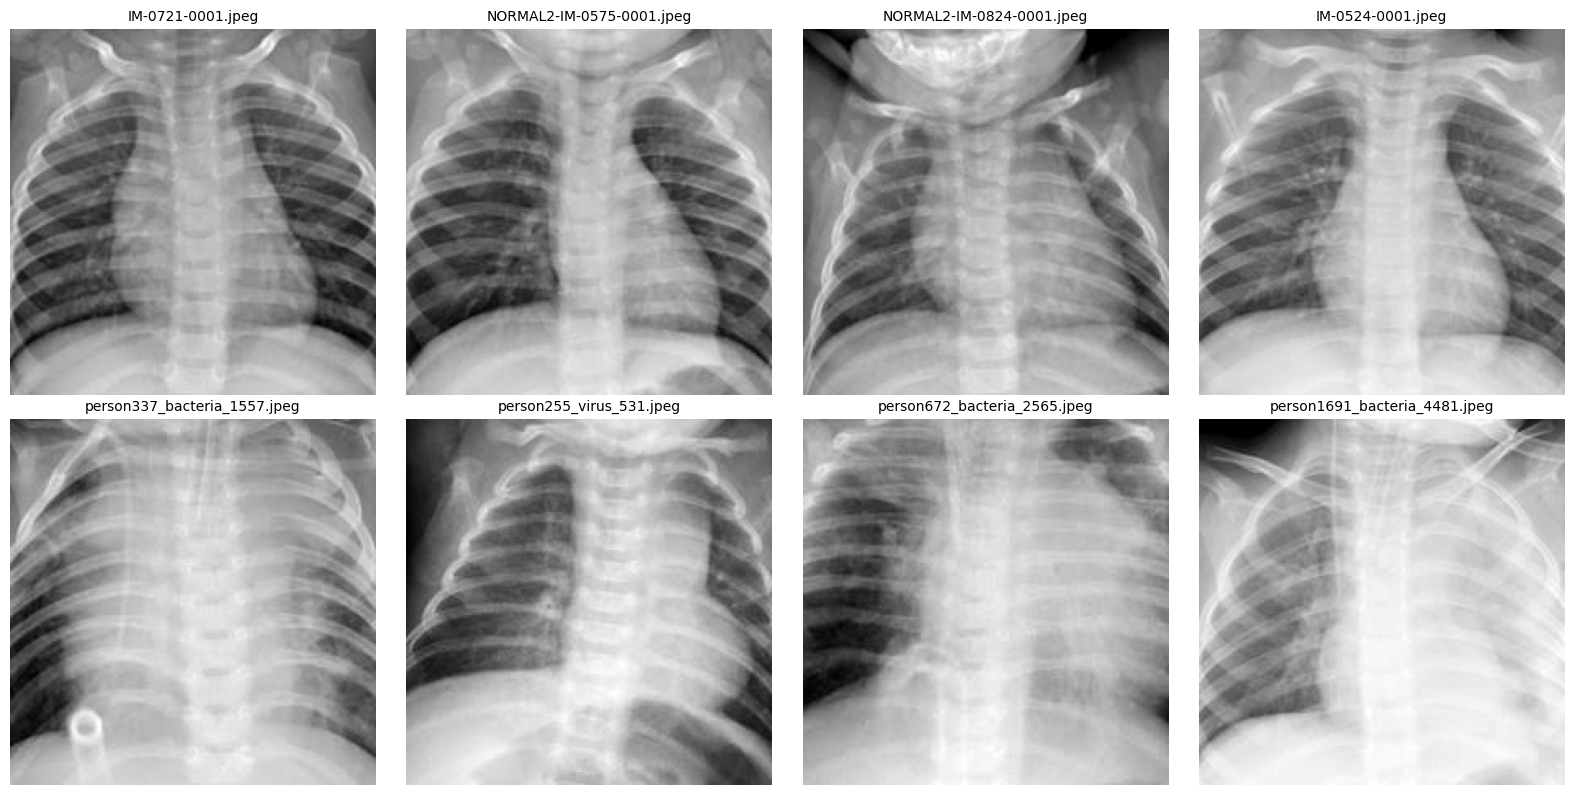

In [97]:
fig, axes = plt.subplots(2,4, figsize=(16, 8))

nxt_norm_pic = random.sample(trainimages_norm, 4)
nxt_pneu_pic = random.sample(trainimages_pneu, 4)

# Full paths
nxt_norm_pic = [os.path.join(trainimages_norm_dir, fname) for fname in nxt_norm_pic]
nxt_pneu_pic = [os.path.join(trainimages_pneu_dir, fname) for fname in nxt_pneu_pic]

# Combine for plotting
all_imgs = nxt_norm_pic + nxt_pneu_pic

for ax, img_path in zip(axes.flatten(), all_imgs):
  imgs = Image.open(img_path)
  ax.imshow(imgs, cmap = 'gray')
  ax.set_title(os.path.basename(img_path), fontsize=10)
  ax.axis('off')
    
plt.tight_layout()
plt.show()

Note: color is not relevant for differentiation; shapes, edges, and structural features are sufficient for detecting anomalies, so grayscale images are used.

In [99]:
# examine the difference between pneumonia and normal images
# select random image in training normal and pneumonia directories 
normal_path = os.path.join(trainimages_norm_dir, random.choice(os.listdir(trainimages_norm_dir)))
pneu_path = os.path.join(trainimages_pneu_dir, random.choice(os.listdir(trainimages_pneu_dir)))

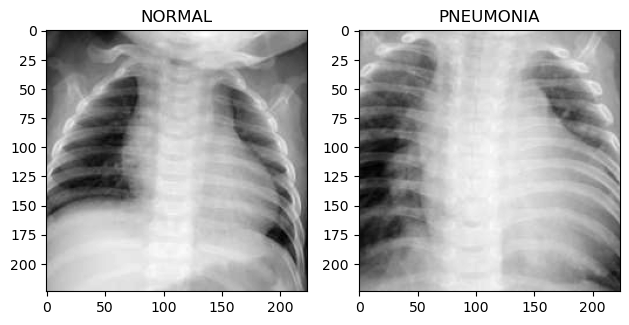

In [101]:
# plot normal and pneumonia image
img_norm = Image.open(normal_path)
img_pneu = Image.open(pneu_path)

# plot side by side
fig, axes = plt.subplots(1,2)

# normal x-ray
axes[0].imshow(img_norm, cmap = "gray")
axes[0].set_title("NORMAL")

# pneumonia x-ray
axes[1].imshow(img_pneu, cmap = "gray")
axes[1].set_title("PNEUMONIA")

plt.tight_layout()
plt.show()

### 1.4 Setting Up Dataloader

In [ ]:
# Define the transformations to apply to the images for use with ResNet-18
transform_mean = [0.485, 0.456, 0.406]
transform_std =[0.229, 0.224, 0.225]
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize(mean=transform_mean, std=transform_std)])

# Apply the image transforms
train_df = ImageFolder('data/chestxrays/train', transform=transform)
test_df = ImageFolder('data/chestxrays/test', transform=transform)

# Create data loaders
train_loader = DataLoader(train_df, batch_size=len(train_df) // 2, shuffle=True)
test_loader = DataLoader(test_df, batch_size=len(test_df))

> Shuffling for randomization and for better model generalization
> Splitting batch size in two to speed up training. Common batch sizes are 32, 64, 128. <br>
> Notes: mean and standard deviation calculated for each color channel (R,G,B)

In [ ]:
# Check image details
image, label = train_df[0]
print(f"Image size: {image.size()}, Label: {label}]")

for images, labels in train_loader:
    print(images.size(), labels.size())

> Notes:
>- torch.Size([150, 3, 224, 224]) torch.Size([150]). <br>
>>- (150) number of images; (3) number of color channels; (224, 224) -dimensions (height & width) <br>
>- ResNet18 accepts 224 x 224 images 

### 2. LOAD AND MODIFY (INSTANTIATE) PRETRAINED MODEL

In [ ]:
# instantiate model
# load pretrained model: resnet18 
resnet18 = models.resnet18(weights="IMAGENET1K_V1")
for param in resnet18.parameters():
    param.required_grad = False
        
# modify just the last layer
resnet18.fc = nn.Linear(resnet18.fc.in_features, 1)

`Transfer learning:` 
freezing all layers 
-     for param in resnet18.parameters():
          param.requires_grad = False  # Freeze all layers
      resnet18.fc = torch.nn.Linear(resnet18.fc.in_features, 10)  # New classifier
`Fine-tuning:` 
for freezing some, but not all, layers
-     for name, param in resnet18.named_parameters():
          if "layer4" in name or "fc" in name:  # Unfreeze last layers
              param.requires_grad = True
          else:
              param.requires_grad = False  # Freeze others

In [ ]:
# run model on GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)  # Sending model to device

### 3. DEFINE TRAINING LOOP

In [ ]:
def train(model, train_loader, criterion, optimizer, num_epochs):

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_accuracy = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device).float(), labels.to(device).float()
            
            # reset gradients
            optimizer.zero_grad()
            
        # forward pass
            outputs = model(images)
            # predictions
            preds = torch.sigmoid(outputs) > 0.5 # binary classification
            # compute loss 
            loss = criterion(outputs.squeeze(), labels) # compare output to ground truth

        # backward pass
            loss.backward()
            # update weights (& bias?)
            optimizer.step()

            # update training loss and accuracy
            running_loss += loss.item()*images.size(0)
            running_accuracy += torch.sum(preds == labels.data)

        # calculate training loss and accuracy for the current epoch
        train_loss = running_loss / len(train_df) 
        train_acc = running_accuracy.double() / len(train_df)

        # print epoch results
        print('Epoch [{}/{}, train loss: {:.4f}, train acc: {:.4f}'.format(epoch+1, num_epochs, train_loss, train_acc))
        

### 4. FINE-TUNING MODEL

In [ ]:
# specify model
model = resnet18

#### 4.1 Loss Function & Optimizer 
> `Loss Function:` measures prediction's deviation from the ground truth 
  >- most common: cross entropy loss
  >- others include: mse, BCEWithLogitsLoss (Binary cross entropy with logits - combination of sigmoid & binary cross-entropy loss together)

> `Optimizer:` algorithm that updates weights and bias in order to minimize loss
  >- most common: SGD (stochastic gradient descent) - better for fine-tuning 
  >- others include: Adam (adapative moment estimation) - earlier layers, faster convergence, might lead to overfitting

In [ ]:
# specify loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(
    resnet18.fc.parameters(), # only last layer is optimized
    lr=0.005, # lr should be kept low so that the pre-trained weights don't change easily
    momentum = 0.9
)  

In [ ]:
# train model 
train(model, train_loader, criterion, optimizer, num_epochs = 3)

### 5. MODEL VALIDATION

In [ ]:
# move some images from training to validation folder
    # def move_files(orig_dir, dest_dir, n=50):
    #     if not os.path.exists(dest_dir):
    #         os.makedirs(dest_dir)
    #     files = os.listdir(orig_dir)
    #     random_files = random.sample(files, n)
    #     for file in random_files:
    #         shutil.move(os.path.join(orig_dir, file), os.path.join(dest_dir, file))
    
    # # move both normal and pneumonia images
    # move_files(trainimages_norm_dir, "data/chestxrays/val/NORMAL")
    # move_files(trainimages_pneu_dir, "data/chestxrays/val/PNEUMONIA")  

# check filenames in VAL directories
valimages_pneu = os.listdir('data/chestxrays/val/PNEUMONIA')
valimages_norm = os.listdir('data/chestxrays/val/NORMAL') 

In [ ]:
print(f"\nFilenames for Validation Pneumonia Images:\n\n{valimages_pneu[:10]}")
print(f"\nFilenames for Validation Normal Images:\n\n{valimages_norm[:10]}")

In [ ]:
# setting up dataloader
# Apply the image transforms
val_df = ImageFolder('data/chestxrays/train', transform=transform)

# Create data loaders
val_loader = DataLoader(val_df, batch_size=len(val_df)) 

In [ ]:
# double-check
image, label = val_df[0]
print(f"Image size: {image.size()}, Label: {label}]")

for images, labels in val_loader:
    print(images.size(), labels.size())

In [ ]:
def val(model, val_loader, criterion):

    # initialize running loss and running accuracy
    running_loss = 0.0
    running_accuracy = 0.0
    
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            preds = torch.sigmoid(outputs).round()  # Round to 0 or 1
            loss = criterion(outputs.squeeze(), labels) # compare output to ground truth

            # update validation loss and accuracy
            running_loss += loss.item()*images.size(0)
            running_accuracy += torch.sum(preds == labels.data)

        # calculate validation loss and accuracy for the current epoch
        val_loss = running_loss / len(val_df) 
        val_acc = running_accuracy.double() / len(val_df)

        # print epoch results
        print('Epoch [{}/{}, val loss: {:.4f}, val acc: {:.4f}'.format(epoch+1, num_epochs, val_loss, val_acc))
        

### 6. MODEL EVALUATION

In [ ]:
# Set model to evaluation mode
model = resnet18
model.eval()

# Initialize metrics for accuracy and F1 score
accuracy_metric = Accuracy(task="binary")
f1_metric = F1Score(task="binary")

# Create lists store all predictions and labels
all_preds = []
all_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
  for images, labels in test_loader:
    # Forward pass
    outputs = model(images)
    preds = torch.sigmoid(outputs).round()  # Round to 0 or 1

    # Extend the lists with predictions and labels
    all_preds.extend(preds.tolist())
    all_labels.extend(labels.unsqueeze(1).tolist())

    # Convert lists back to tensors
    all_preds = torch.tensor(all_preds)
    all_labels = torch.tensor(all_labels)

    # Calculate accuracy and F1 score
    test_acc = accuracy_metric(all_preds, all_labels).item()
    test_f1 = f1_metric(all_preds, all_labels).item()

print(f"\nTest accuracy: {test_acc:.3f}\nTest F1-Score: {test_f1:.3f}")